In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tempfile, sys, os
sys.path.insert(0, os.path.abspath('..'))

import os
import keras 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


from keras.models import Model
from keras.layers import Activation
from keras import backend as K
# Import DeepExplain
from deepexplain.tensorflow import DeepExplain

Using TensorFlow backend.


In [2]:
# 0 - Tumor
# 1 - Normal
encoder = OneHotEncoder()
encoder.fit([[0], [1]]) 

OneHotEncoder()

In [3]:
# This cell updates result list for images with tumor

data = []
paths = []
result = []

for r, d, f in os.walk(r'D:/Courses/CSC3180/Project/demo/datasets/brain-tumor-mri-detection/yes'):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))

for path in paths:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[0]]).toarray())

In [4]:
# This cell updates result list for images without tumor

paths = []
for r, d, f in os.walk(r"D:/Courses/CSC3180/Project/demo/datasets/brain-tumor-mri-detection/no"):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))

for path in paths:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[1]]).toarray())

In [5]:
data = np.array(data)
data.shape

(139, 128, 128, 3)

In [24]:
result = np.array(result)
result = result.reshape(139,2)

In [25]:
x_train,x_test,y_train,y_test = train_test_split(data, result, test_size=0.2, shuffle=True, random_state=0)

In [26]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(2, 2), input_shape=(128, 128, 3), padding = 'Same'))
model.add(Conv2D(32, kernel_size=(2, 2), activation ='relu', padding = 'Same'))


model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

#new 

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(2, activation='softmax'))

model.compile(loss = "categorical_crossentropy", optimizer='Adamax',metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 128, 128, 32)      416       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 128, 128, 32)      4128      
_________________________________________________________________
batch_normalization_5 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 64)        8256      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 64, 64, 64)       

In [27]:
model.fit(x_train, y_train, epochs = 30, batch_size = 40, verbose = 1,validation_data = (x_test, y_test))

Train on 111 samples, validate on 28 samples
Epoch 1/30
111/111 [==============================] - 1s 12ms/step - loss: 14.3244 - accuracy: 0.5225 - val_loss: 50.8356 - val_accuracy: 0.5000
Epoch 2/30
111/111 [==============================] - 0s 2ms/step - loss: 12.9068 - accuracy: 0.4865 - val_loss: 9.4028 - val_accuracy: 0.5000
Epoch 3/30
111/111 [==============================] - 0s 2ms/step - loss: 8.3836 - accuracy: 0.5946 - val_loss: 19.7949 - val_accuracy: 0.5357
Epoch 4/30
111/111 [==============================] - 0s 2ms/step - loss: 10.4492 - accuracy: 0.5045 - val_loss: 14.0840 - val_accuracy: 0.5357
Epoch 5/30
111/111 [==============================] - 0s 2ms/step - loss: 4.1943 - accuracy: 0.6847 - val_loss: 15.2764 - val_accuracy: 0.5357
Epoch 6/30
111/111 [==============================] - 0s 2ms/step - loss: 5.3598 - accuracy: 0.6396 - val_loss: 16.8699 - val_accuracy: 0.5000
Epoch 7/30
111/111 [==============================] - 0s 2ms/step - loss: 4.1673 - accuracy: 0

In [10]:
model.save('./models/brain-tumor-model')

In [11]:
from keras.models import load_model
model = load_model('./models/brain-tumor-model')

In [28]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.7535980939865112
Test accuracy: 0.6785714030265808


In [29]:
%%time
with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
    # Need to reconstruct the graph in DeepExplain context, using the same weights.
    # With Keras this is very easy:
    # 1. Get the input tensor to the original model
    input_tensor = model.layers[0].input
    
    # 2. We now target the output of the last dense layer (pre-softmax)
    # To do so, create a new model sharing the same layers untill the last dense (index -2)
    fModel = Model(inputs=input_tensor, outputs = model.layers[-1].output)
    target_tensor = fModel(input_tensor)
    
    xs = x_test[0:4]
    ys = y_test[0:4]
    
    attributions_gradin = de.explain('grad*input', target_tensor, input_tensor, xs, ys=ys)
    attributions_sal   = de.explain('saliency', target_tensor, input_tensor, xs, ys=ys)
    attributions_ig    = de.explain('intgrad', target_tensor, input_tensor, xs, ys=ys)
    # attributions_dl    = de.explain('deeplift', target_tensor, input_tensor, xs, ys=ys)
    attributions_elrp  = de.explain('elrp', target_tensor, input_tensor, xs, ys=ys)
    # attributions_occ   = de.explain('occlusion', target_tensor, input_tensor, xs, ys=ys)
    
    # Compare Gradient * Input with approximate Shapley Values
    # Note1: Shapley Value sampling with 100 samples per feature (78400 runs) takes a couple of minutes on a GPU.
    # Note2: 100 samples are not enough for convergence, the result might be affected by sampling variance
    # attributions_sv     = de.explain('shapley_sampling', target_tensor, input_tensor, xs, ys=ys, samples=100)

Wall time: 4.83 s


Wall time: 581 ms


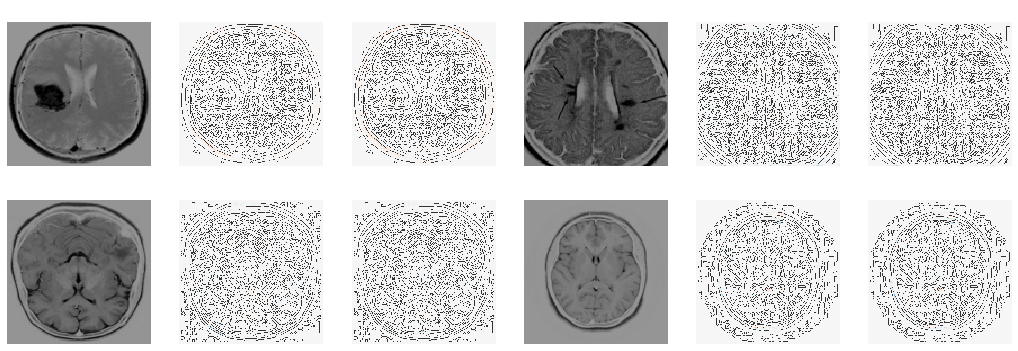

In [30]:
%%time
from utils import plot, plt
%matplotlib inline

n_cols = 6
n_rows = int(len(attributions_gradin) / 2)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols, 3*n_rows))

for i, (a1, a2) in enumerate(zip(attributions_gradin, attributions_ig)):
    row, col = divmod(i, 2)
    plot(xs[i].reshape(128, 128, 3), cmap='Greys', axis=axes[row, col*3]).set_title('Original')
    plot(a1.reshape(128, 128, 3), xi = xs[i], axis=axes[row,col*3+1]).set_title('Grad*Input')
    plot(a2.reshape(128, 128, 3), xi = xs[i], axis=axes[row,col*3+2]).set_title('Integrated Gradient')

In [ ]:
%%time
from utils import plot, plt
%matplotlib inline

n_cols = 6
n_rows = int(len(attributions_dl) / 2)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols, 3*n_rows))

for i, (a1, a2) in enumerate(zip(attributions_dl, attributions_elrp)):
    row, col = divmod(i, 2)
    plot(xs[i].reshape(128, 128, 3), cmap='Greys', axis=axes[row, col * 3]).set_title('Original')
    plot(a1.reshape(128, 128, 3), xi = xs[i], axis=axes[row,col * 3 + 1]).set_title('DeepLift')
    plot(a2.reshape(128, 128, 3), xi = xs[i], axis=axes[row,col * 3 + 2]).set_title('E-LRP')

NameError: name 'attributions_dl' is not defined